In [35]:
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

## Read data as pd DataFrame

In [2]:
with open('../Astr511HW1data.dat', 'r') as ff:
    line1 = ff.readline()
    cols = line1.strip('#').split()

df = pd.read_csv('../Astr511HW1data.dat', comment='#', delim_whitespace=True, names=cols)

In [3]:
df.head()

,ra,dec,run,Ar,u,g,r,i,z,uErr,gErr,rErr,iErr,zErr,pmL,pmB,pmErr
0,181.61220,27.57260,5087,0.05,16.40,15.24,14.80,14.73,14.69,0.02,0.02,0.02,0.02,0.01,5.16,-1.45,2.72
1,181.61303,27.60770,5087,0.05,21.84,19.55,18.40,18.04,17.79,0.18,0.02,0.02,0.02,0.02,5.48,4.73,3.16
2,181.61416,27.35956,5112,0.05,19.76,17.56,16.61,16.23,16.07,0.03,0.01,0.02,0.03,0.03,3.14,7.92,2.79
3,181.61640,27.82464,5112,0.06,21.73,20.63,20.19,19.99,20.04,0.16,0.03,0.03,0.03,0.13,19.13,-1.08,5.08
4,181.62112,28.01623,5087,0.05,21.37,20.38,20.11,20.05,19.87,0.11,0.04,0.03,0.03,0.09,-3.65,-8.00,4.91


## Calculate Metalliticites Fe/H

\begin{equation}
[Fe/H] = A + Bx + Cy + Dxy + Ex^2 + Fy^2 + Gx^2y + Hxy^2 + Ix^3 + Jy^3
\end{equation}
$x = (u - g) \\
y = (g - r) \\
(A - J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20)$

In [4]:
df['x'] = df['u'] - df['g']
df['y'] = df['g'] - df['r']

coeff = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20)
A, B, C, D, E, F, G, H, I, J = coeff

metallicity = lambda x, y: A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x**2*y + H*x*y**2 + I*x**3 + J*y**3

df['Fe/H'] = -0.6
df.loc[(df['y'] < 0.6), 'Fe/H'] = metallicity(df.loc[(df['y'] < 0.6), 'x'], df.loc[(df['y'] < 0.6), 'y'])

## Calculate Absolute Mag in r from Fe/H and g - r

#### Fiducial Abs Mag in r $M^0_r$
A7
\begin{equation}
M^0_r (g - i) = -5.06 + 14.32x - 12.97x^2 + 6.127x^3 - 1.267x^4 + 0.0967x^5
\end{equation}

#### Metalicity Correction $\Delta M_r$
A2
\begin{equation}
\Delta M_r([Fe/H]) = 4.50 - 1.11 [Fe/H] - 0.18[Fe/H]^2
\end{equation}

#### Fitted Abs Mag in r $M_r$
A3
\begin{equation}
M_r(g - i, [Fe/H]) = M^0_r (g - i) + \Delta M_r([Fe/H])
\end{equation}




In [6]:
# A2
df['DelMr'] = 4.50 - 1.11 * df['Fe/H'] - 0.18 * df['Fe/H'] ** 2

# A7
fiducial_M_r = lambda x: -5.06 + 14.32*x - 12.97*x**2 + 6.127*x**3 - 1.267*x**4 + 0.0967*x**5
df['FidcMr'] = fiducial_M_r(df['g'] - df['i'])

# A3
df['Mr'] = df['FidcMr'] + df['DelMr']

## Calculate Z, distance above galactic plane

For distance from galactic plane Z

We assume 

$Z = D$

and 

$r - M_r = 5 * log(D/(10pc))$

Solving for D:

$D = 10^{0.2 * (r - M_r) + 1} pc$


In [7]:
df['D'] = 10 ** ((df['r'] - df['Mr']) / 5) * 10  # pc

## Problem 1
For stars with $0.2 < g - r < 0.4$, plot $ln(\rho)$ vs. $Z$ where $\rho$ is the stellar number density in a given bin, Approximate 

$\rho(Z) = N(Z) / V(Z)$

where N is the number of stars in a given bin, V is the bin volume.

In [13]:
gr24 = df.loc[((df['g'] - df['r']) < 0.4) & ((df['g'] - df['r']) > 0.2)]

In [107]:
sa = (314 * u.deg **2).to(u.sr).value
dV = (np.arange(1, 25) **2 * sa * 1 + np.arange(0, 24) **2 * sa * 1) / 2


In [108]:
dV

array([4.78249349e-02, 2.39124675e-01, 6.21724154e-01, 1.19562337e+00,
       1.96082233e+00, 2.91732103e+00, 4.06511947e+00, 5.40421764e+00,
       6.93461556e+00, 8.65631322e+00, 1.05693106e+01, 1.26736078e+01,
       1.49692046e+01, 1.74561012e+01, 2.01342976e+01, 2.30037937e+01,
       2.60645895e+01, 2.93166851e+01, 3.27600804e+01, 3.63947755e+01,
       4.02207703e+01, 4.42380648e+01, 4.84466591e+01, 5.28465531e+01])

In [88]:
np.arange(24)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [89]:
V = 1/3 * np.pi * sa * np.arange(2, 26)**3 - (1/3 * np.pi * sa * np.arange(1, 25)**3)

In [109]:
V/dV

array([14.66075195,  7.95869391,  5.96096508,  5.11031925,  4.6485311 ,
        4.36045784,  4.16414635,  4.0219762 ,  3.91434855,  3.83007805,
        3.76232613,  3.70668068,  3.66016947,  3.620718  ,  3.5868348 ,
        3.55742036,  3.53164641,  3.50887724,  3.48861689,  3.47047272,
        3.45412994,  3.43933316,  3.42587307,  3.4135765 ])

In [171]:
def get_vol_elements(n, bin_size, bin_start, solid_angle, method='avg', disp=False):
    def puck_vol(distance, sa, thickness):
        return sa * distance ** 2 * thickness
    def cone_vol(distance, sa):
        return 1/3 * np.pi * distance ** 2 * sa * distance
    
    lower_bound = np.arange(bin_start, round(bin_size * n + bin_start, 6), bin_size)
    upper_bound = np.arange(bin_start + bin_size, round(bin_size * (n + 1) + bin_start, 6), bin_size)
    lower_bound = np.round(lower_bound, 6)
    upper_bound = np.round(upper_bound, 6)
    
    
    if method == 'avg':
        dVs =  0.5 * (puck_vol(lower_bound, solid_angle, bin_size) + 
                      puck_vol(upper_bound, solid_angle, bin_size))
        
    elif method == 'lower':
        dVs = puck_vol(lower_bound, solid_angle, bin_size)
            
    elif method == 'upper':
        dVs = puck_vol(upper_bound, solid_angle, bin_size)
        
    elif method = 'cone':
        dVs = cone_vol(upper_bound) - cone_vol(lower_bound, solid_angle)
    
    if disp:
        for ii in range(n):
            print(f'from {lower_bound[ii]} to {upper_bound[ii]}:\t {dVs[ii]}')
    
    


In [174]:
get_vol_elements(40, 0.4, 0.8, sa, 'avg', disp=True)

from 0.8 to 1.2:	 0.03979034584221902
from 1.2 to 1.6:	 0.07651989585042121
from 1.6 to 2.0:	 0.12549262919469079
from 2.0 to 2.4:	 0.18670854587502772
from 2.4 to 2.8:	 0.26016764589143204
from 2.8 to 3.2:	 0.3458699292439038
from 3.2 to 3.6:	 0.443815395932443
from 3.6 to 4.0:	 0.5540040459570494
from 4.0 to 4.4:	 0.6764358793177234
from 4.4 to 4.8:	 0.8111108960144648
from 4.8 to 5.2:	 0.9580290960472735
from 5.2 to 5.6:	 1.1171904794161494
from 5.6 to 6.0:	 1.2885950461210929
from 6.0 to 6.4:	 1.4722427961621039
from 6.4 to 6.8:	 1.668133729539182
from 6.8 to 7.2:	 1.8762678462523277
from 7.2 to 7.6:	 2.0966451463015408
from 7.6 to 8.0:	 2.3292656296868213
from 8.0 to 8.4:	 2.5741292964081692
from 8.4 to 8.8:	 2.831236146465585
from 8.8 to 9.2:	 3.100586179859067
from 9.2 to 9.6:	 3.382179396588617
from 9.6 to 10.0:	 3.6760157966542346
from 10.0 to 10.4:	 3.9820953800559193
from 10.4 to 10.8:	 4.300418146793672
from 10.8 to 11.2:	 4.630984096867492
from 11.2 to 11.6:	 4.97379323027

In [110]:
np.clip(4.8/.4

11.999999999999998

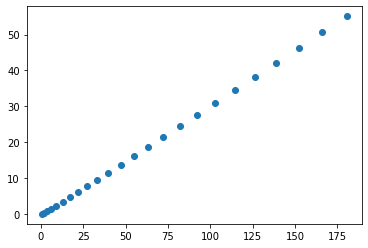

In [91]:
plt.scatter(V, dV)

In [85]:
V

array([1.00164215e-01, 7.01149507e-01, 1.90312009e+00, 3.70607597e+00,
       6.11001714e+00, 9.11494360e+00, 1.27208553e+01, 1.69277524e+01,
       2.17356347e+01, 2.71445024e+01, 3.31543553e+01, 3.97651935e+01,
       4.69770170e+01, 5.47898258e+01, 6.32036199e+01, 7.22183993e+01,
       8.18341639e+01, 9.20509139e+01, 1.02868649e+02, 1.14287370e+02,
       1.26307076e+02, 1.38927767e+02, 1.52149443e+02, 1.65972105e+02])

In [84]:
sum((gr24['D(kpc)'] < 5.2) & (gr24['D(kpc)'] > 4.8)) 

2590

In [18]:
gr24 # kpc ^ 3

array([ 0.09564978,  0.38259912,  0.86084802,  1.53039648,  2.3912445 ,
        3.44339208,  4.68683922,  6.12158592,  7.74763218,  9.564978  ,
       11.57362338, 13.77356832, 16.16481281, 18.74735687, 21.52120049,
       24.48634367, 27.64278641, 30.99052871, 34.52957057, 38.25991199,
       42.18155296, 46.2944935 , 50.5987336 , 55.09427326, 59.78111248])

(array([7952., 8015., 6797., 6608., 6715., 7039., 7278., 7498., 7137.,
        6649., 5885., 5041., 4354., 3451., 2846., 2295., 1986., 1581.,
        1275., 1037.,  808.,  728.,  570.,  479.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 24 Patch objects>)

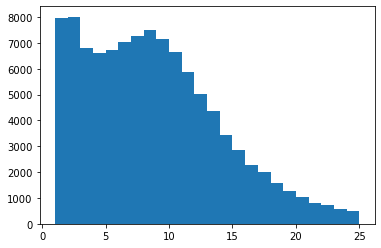

In [40]:
plt.hist(gr24['D(kpc)'], bins=np.arange(1,26))

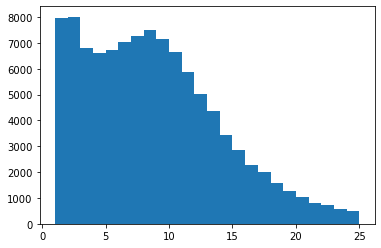

In [38]:
n, b, p = plt.hist(gr24['D(kpc)'], bins=np.arange(1,26))

In [95]:
np.log(n/V)

array([9.33621289, 8.34557537, 7.51426299, 6.98610674, 6.60218389,
       6.31597859, 6.06365695, 5.84343853, 5.57187326, 5.30104766,
       4.99717003, 4.67570127, 4.37534573, 4.00005775, 3.67397493,
       3.33379331, 3.07153601, 2.73235991, 2.41198539, 2.10537116,
       1.76060792, 1.56543783, 1.23381663, 0.97654754])

Text(0, 0.5, '$ln(\\rho/\\rho_0)$')

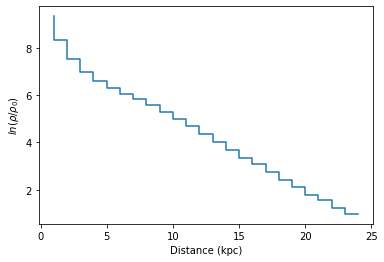

In [94]:
plt.step(np.arange(1,25), np.log(n/V))
plt.xlabel('Distance (kpc)')
plt.ylabel(r'$ln(\rho/\rho_0)$')

Text(0, 0.5, '$ln(\\rho/\\rho_0)$')

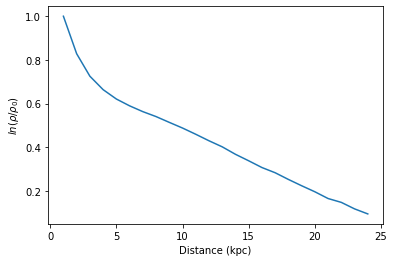

In [78]:
dens = np.log(n/V)
plt.plot(np.arange(1,25), dens/max(dens))
plt.xlabel('Distance (kpc)')
plt.ylabel(r'$ln(\rho/\rho_0)$')

#### len(dV)

In [25]:
sa

0.09564977996530628

In [24]:
gr24['D(kpc)'] = gr24['D'] / 1000

<ipython-input-24-bf1b8f757584>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr24['D(kpc)'] = gr24['D'] / 1000


In [ ]:
gr24['bin'] = gr24.

In [28]:
test = np.array([])

In [18]:
np.loadtxt('../Astr511HW1data.dat')

array([[ 1.8161220e+02,  2.7572600e+01,  5.0870000e+03, ...,
         5.1600000e+00, -1.4500000e+00,  2.7200000e+00],
       [ 1.8161303e+02,  2.7607700e+01,  5.0870000e+03, ...,
         5.4800000e+00,  4.7300000e+00,  3.1600000e+00],
       [ 1.8161416e+02,  2.7359560e+01,  5.1120000e+03, ...,
         3.1400000e+00,  7.9200000e+00,  2.7900000e+00],
       ...,
       [ 2.0409455e+02,  2.7858230e+01,  4.6490000e+03, ...,
         9.9999000e+02,  9.9999000e+02,  9.9999000e+02],
       [ 2.0409851e+02,  2.8014000e+01,  4.6460000e+03, ...,
         9.9999000e+02,  9.9999000e+02,  9.9999000e+02],
       [ 2.0410122e+02,  2.7556730e+01,  4.6460000e+03, ...,
         9.9999000e+02,  9.9999000e+02,  9.9999000e+02]])

In [32]:
from astropy.table import Table

In [37]:
data = Table.read('../Astr511HW1data.dat', format='ascii')

In [36]:
data

<_io.TextIOWrapper name='../Astr511HW1data.dat' mode='r' encoding='cp1252'>

In [29]:
(314 * u.deg ** 2).to(u.sr)

<Quantity 0.09564987 sr>